In [1]:
pip install numpy pandas librosa matplotlib scikit-learn tensorflow streamlit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 83.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 97.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.4 MB/s eta 0:00:00


In [12]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [15]:
# Define your directories in Google Drive

# Assuming the Ravdess folder is in the root of your Google Drive
speech_dir = '/content/drive/MyDrive/Ravdess/Speech'
song_dir = '/content/drive/MyDrive/Ravdess/Song'


def get_ravdess_dataframe(base_dir):
    ravdess_directory_list = os.listdir(base_dir)
    file_emotion = []
    file_path = []

    for dir_name in ravdess_directory_list:
        actor_path = os.path.join(base_dir, dir_name)
        if not os.path.isdir(actor_path):
            continue
        for file in os.listdir(actor_path):
            part = file.split('.')[0].split('-')
            emotion_code = int(part[2])
            file_emotion.append(emotion_code)
            file_path.append(os.path.join(actor_path, file))

    # Create dataframe
    emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
    path_df = pd.DataFrame(file_path, columns=['Path'])
    df = pd.concat([emotion_df, path_df], axis=1)
    df.Emotions.replace({
        1: 'neutral', 2: 'calm', 3: 'happy', 4: 'sad',
        5: 'angry', 6: 'fear', 7: 'disgust', 8: 'surprise'
    }, inplace=True)
    return df

# Combine both speech and song
speech_df = get_ravdess_dataframe(speech_dir)
song_df = get_ravdess_dataframe(song_dir)
ravdess_df = pd.concat([speech_df, song_df], axis=0).reset_index(drop=True)

print(ravdess_df.head())

/tmp/ipython-input-15-30774965.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.Emotions.replace({


  Emotions                                               Path
0    happy  /content/drive/MyDrive/Ravdess/Speech/Actor_05...
1    happy  /content/drive/MyDrive/Ravdess/Speech/Actor_05...
2    happy  /content/drive/MyDrive/Ravdess/Speech/Actor_05...
3    happy  /content/drive/MyDrive/Ravdess/Speech/Actor_05...
4    happy  /content/drive/MyDrive/Ravdess/Speech/Actor_05...


/tmp/ipython-input-15-30774965.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.Emotions.replace({


In [17]:
data_path = ravdess_df
data_path.to_csv("data_path.csv",index=False)
data_path.head()

Emotions                                               Path
0    happy  /content/drive/MyDrive/Ravdess/Speech/Actor_05...
1    happy  /content/drive/MyDrive/Ravdess/Speech/Actor_05...
2    happy  /content/drive/MyDrive/Ravdess/Speech/Actor_05...
3    happy  /content/drive/MyDrive/Ravdess/Speech/Actor_05...
4    happy  /content/drive/MyDrive/Ravdess/Speech/Actor_05...

# Data Visualization and Exploration

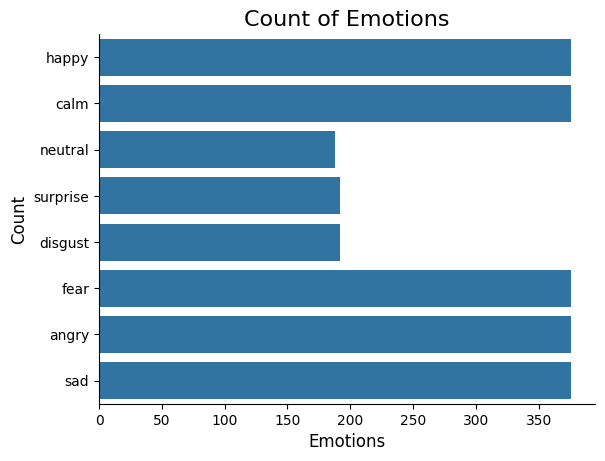

In [18]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [23]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

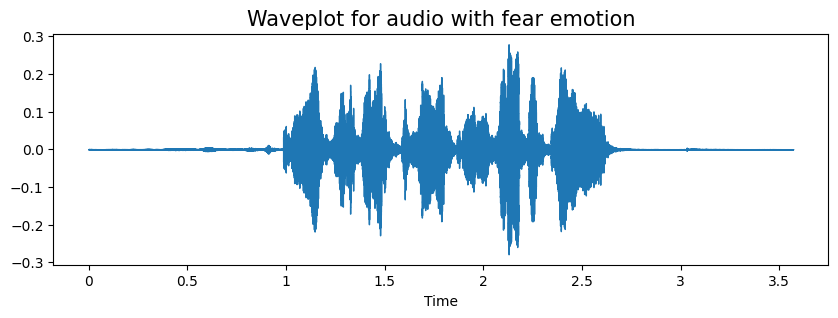

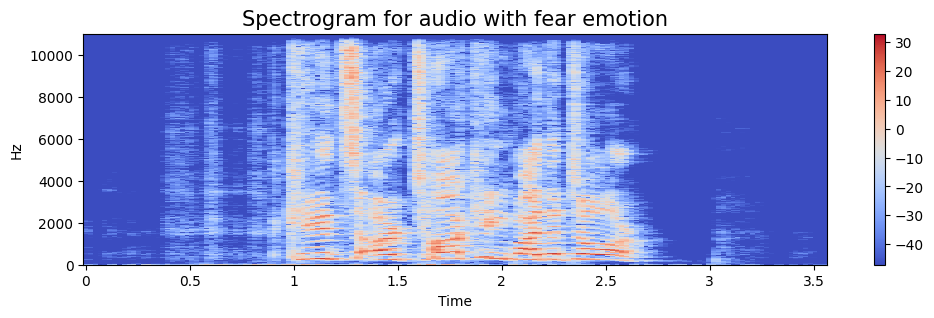

In [24]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

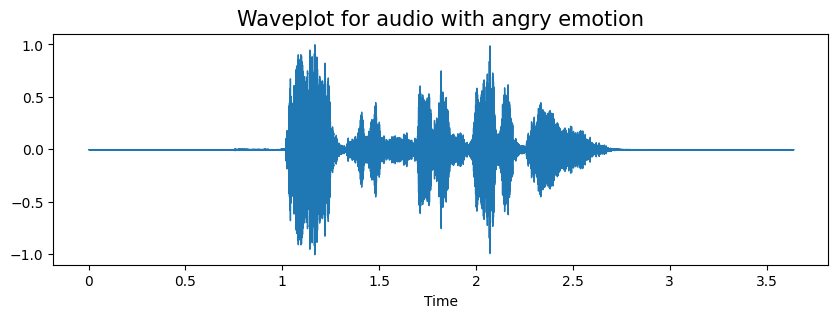

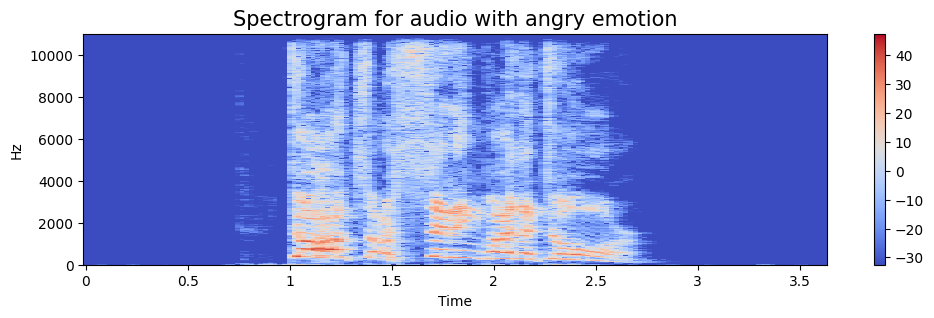

In [25]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

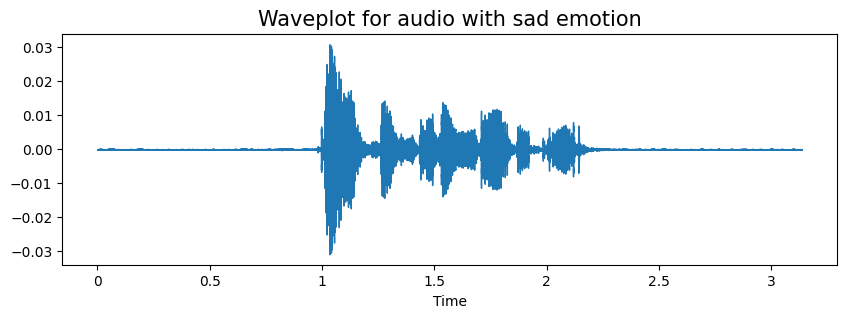

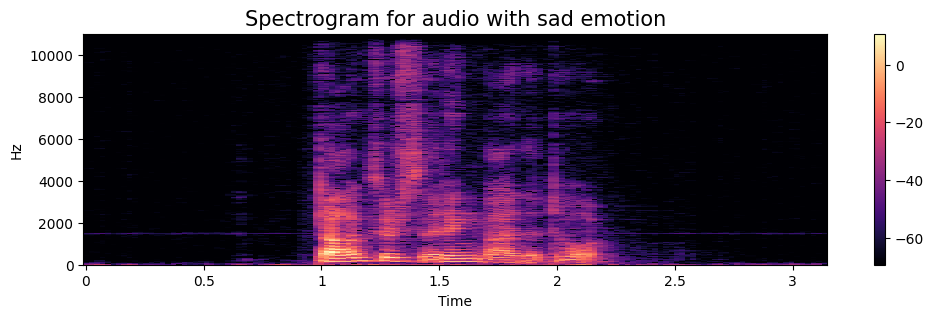

In [26]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

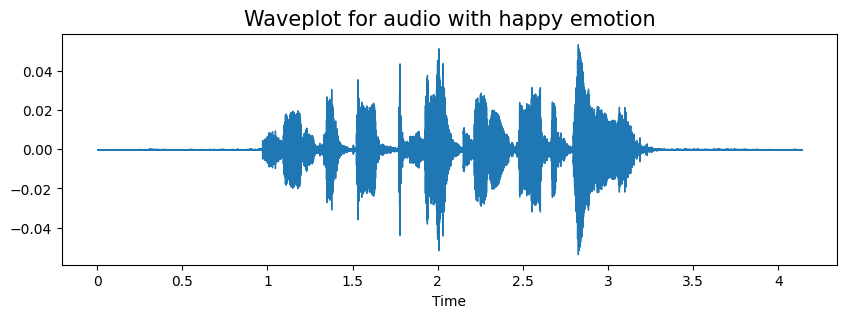

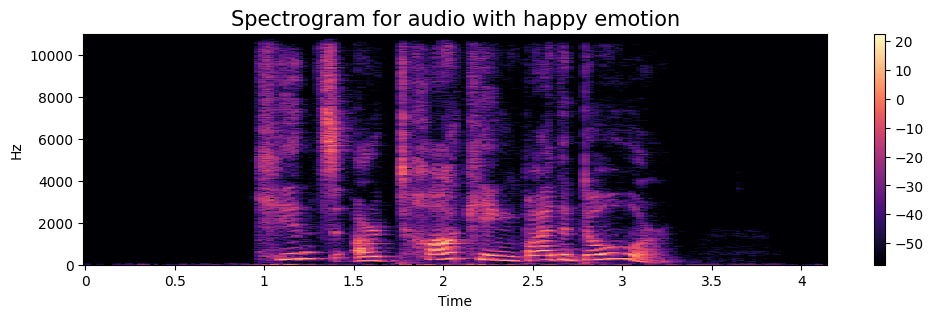

In [27]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

# Data Augmentation


In [33]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    # Pass rate as a keyword argument
    return librosa.effects.time_stretch(y=data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

1.Simple Audio

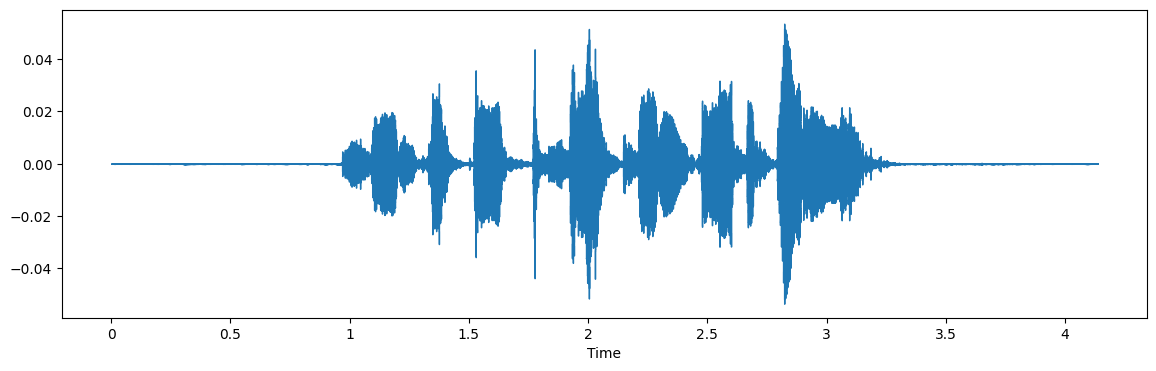

In [30]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

2.Noise Injection

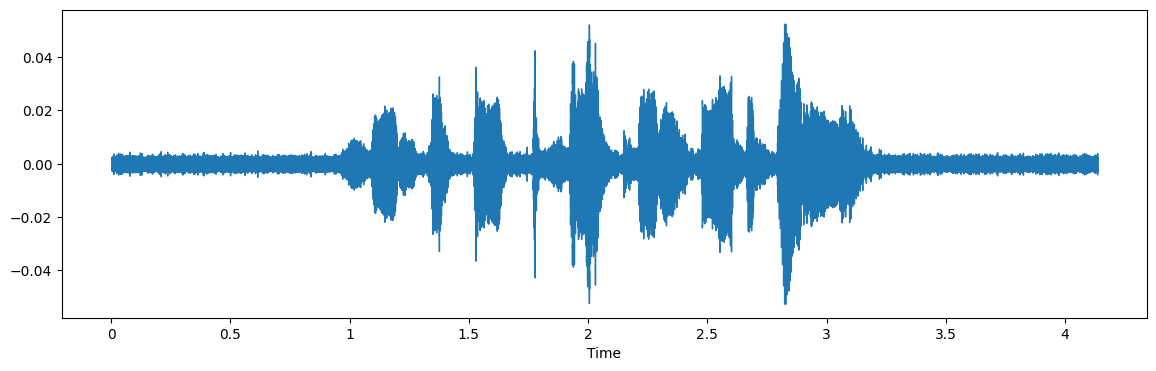

In [31]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

3.Stretching

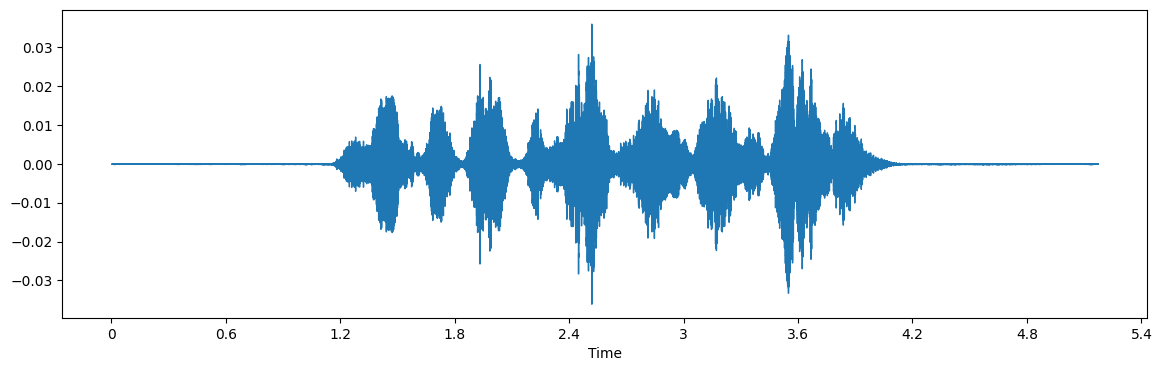

In [34]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

4.Shifting

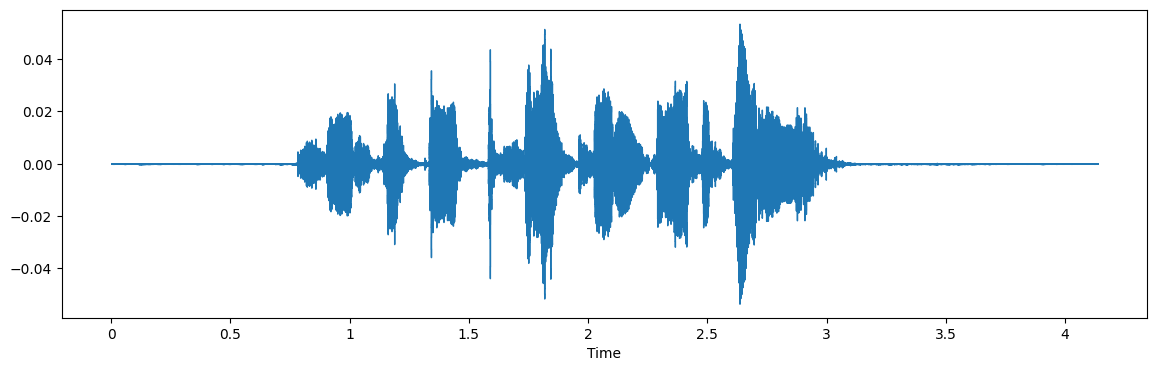

In [38]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

5.Pitch

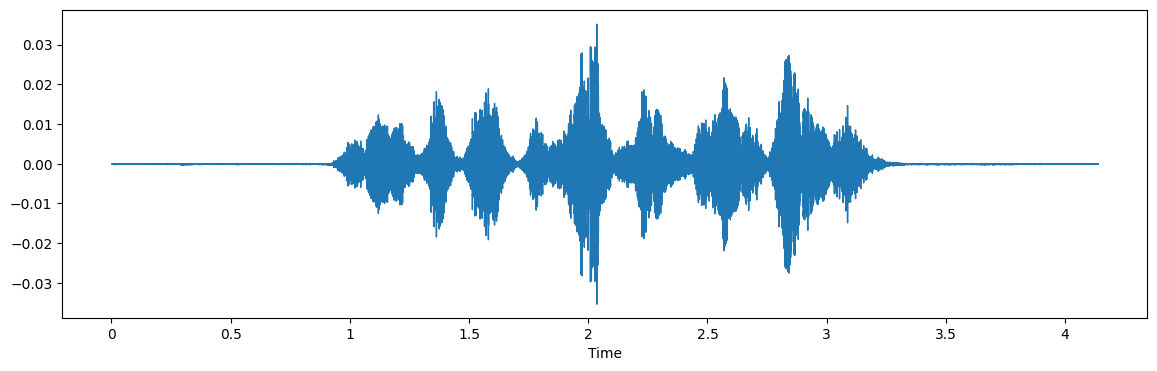

In [36]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

# Feature Extraction

In [39]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically

    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically

    return result

In [40]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [41]:
len(X), len(Y), data_path.Path.shape

(7356, 7356, (2452,))

In [42]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

0         1         2         3         4         5         6  \
0  0.144409  0.538728  0.581974  0.667334  0.710844  0.724930  0.721856   
1  0.287263  0.667345  0.699196  0.748791  0.795237  0.805871  0.728635   
2  0.119538  0.566934  0.524018  0.548618  0.655513  0.699129  0.728555   
3  0.153162  0.553104  0.628683  0.592988  0.514583  0.499018  0.503114   
4  0.226391  0.633097  0.689836  0.622746  0.568564  0.568387  0.528281   

          7         8         9  ...       153       154       155       156  \
0  0.708156  0.669505  0.605123  ...  0.000049  0.000052  0.000062  0.000056   
1  0.700045  0.701035  0.664967  ...  0.000397  0.000411  0.000428  0.000399   
2  0.717080  0.662348  0.663435  ...  0.000008  0.000010  0.000010  0.000012   
3  0.509621  0.557389  0.559404  ...  0.000091  0.000092  0.000078  0.000074   
4  0.540198  0.582309  0.580503  ...  0.000133  0.000136  0.000117  0.000113   

        157       158       159       160           161  labels  
0  0.000046  0.000040  0.000032  0.000015  1.003502e-06   happy  
1  0.000391  0.000397  0.000374  0.000362  3.387859e-04   happy  
2  0.000013  0.000010  0.000006  0.000004  2.952557e-07   happy  
3  0.000089  0.000060  0.000046  0.000024  1.912973e-06   happy  
4  0.000130  0.000102  0.000088  0.000064  4.125315e-05   happy  

[5 rows x 163 columns]

# Data Preparation

In [43]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [44]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [45]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5517, 162), (5517, 8), (1839, 162), (1839, 8))

In [46]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5517, 162), (5517, 8), (1839, 162), (1839, 8))

In [47]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5517, 162, 1), (5517, 8), (1839, 162, 1), (1839, 8))

# Modelling

In [48]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 162, 256)       │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 81, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 81, 256)        │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 41, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 41, 128)        │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 21, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 21, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 21, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 11, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 704)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        22,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 557,288 (2.13 MB)

 Trainable params: 557,288 (2.13 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 41s 418ms/step - accuracy: 0.2154 - loss: 1.9692 - val_accuracy: 0.2920 - val_loss: 1.7976 - learning_rate: 0.0010
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 41s 422ms/step - accuracy: 0.2738 - loss: 1.8122 - val_accuracy: 0.3404 - val_loss: 1.6904 - learning_rate: 0.0010
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 42s 438ms/step - accuracy: 0.3286 - loss: 1.6923 - val_accuracy: 0.3915 - val_loss: 1.5939 - learning_rate: 0.0010
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 43s 459ms/step - accuracy: 0.3543 - loss: 1.6178 - val_accuracy: 0.4367 - val_loss: 1.4917 - learning_rate: 0.0010
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 40s 453ms/step - accuracy: 0.4075 - loss: 1.5276 - val_accuracy: 0.4611 - val_loss: 1.3989 - learning_rate: 0.0010
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 38s 414ms/step - accuracy: 0.4344 - loss: 1.4622 - val_accuracy: 0.4867 - val_loss: 1.3321 - learning_rate: 0.0010
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 41s 410ms/step - accuracy: 0.4649 - loss: 1.

58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.7247 - loss: 1.1600
Accuracy of our model on test data :  71.83251976966858 %


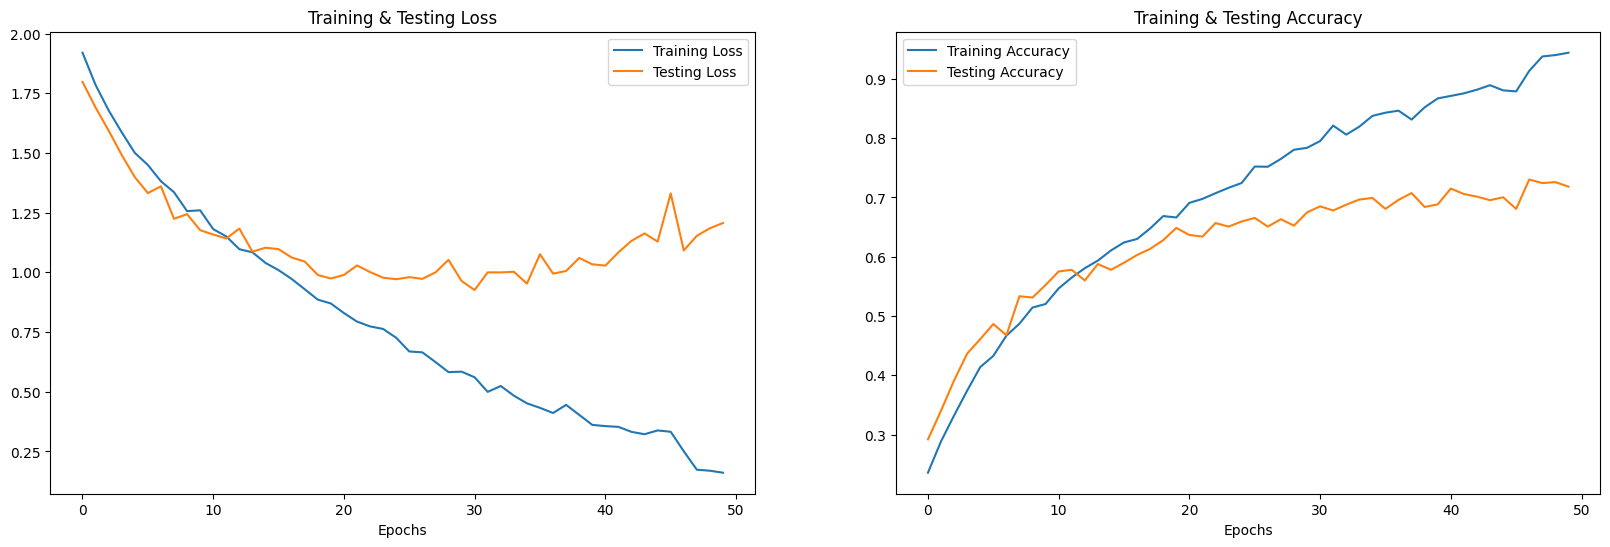

In [51]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [52]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step


In [53]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

Predicted Labels Actual Labels
0             fear          fear
1             fear           sad
2          neutral         angry
3              sad           sad
4              sad          fear
5            angry         angry
6              sad          fear
7          neutral       neutral
8              sad           sad
9             fear          fear

<function matplotlib.pyplot.show(close=None, block=None)>

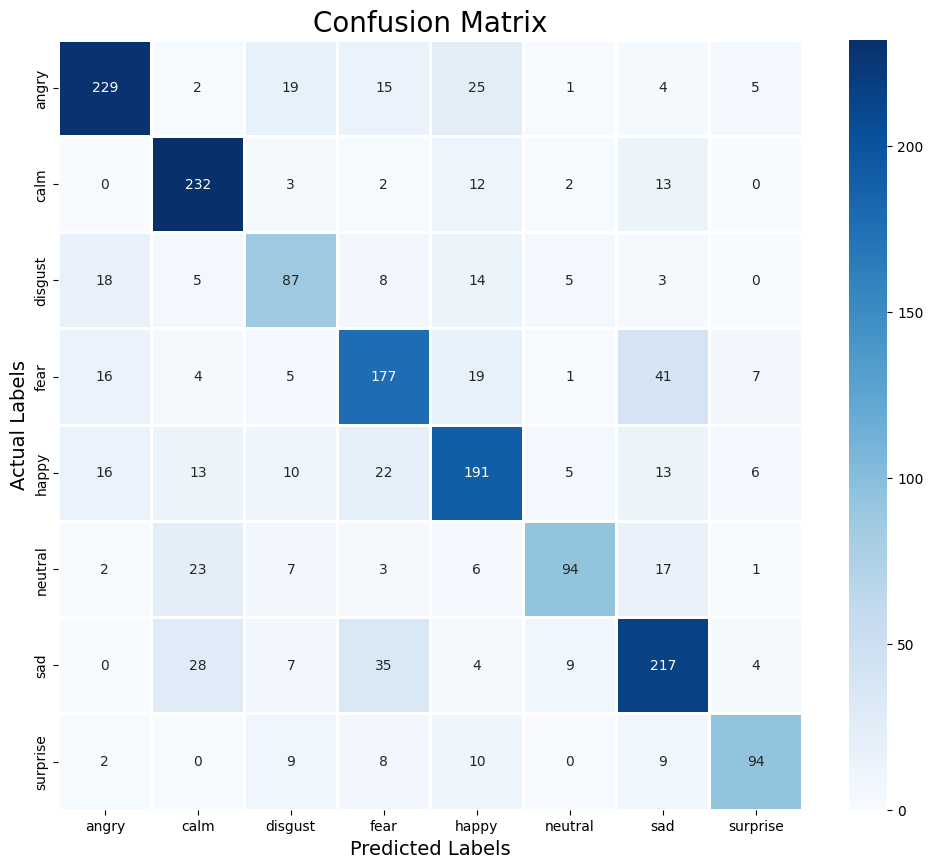

In [55]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show

In [56]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.81      0.76      0.79       300
        calm       0.76      0.88      0.81       264
     disgust       0.59      0.62      0.61       140
        fear       0.66      0.66      0.66       270
       happy       0.68      0.69      0.69       276
     neutral       0.80      0.61      0.70       153
         sad       0.68      0.71      0.70       304
    surprise       0.80      0.71      0.76       132

    accuracy                           0.72      1839
   macro avg       0.72      0.71      0.71      1839
weighted avg       0.72      0.72      0.72      1839



In [61]:
model.save("emotion_classification_model.h5")

In [62]:
from google.colab import files
files.download("emotion_classification_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [57]:
#Build the model

# define model
"""model000 = Sequential()
model000.add(Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X.shape[1], 1)))
model000.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model000.add(BatchNormalization())
model000.add(Dropout(0.3))


model000.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
model000.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model000.add(BatchNormalization())
model000.add(Dropout(0.3))

model000.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model000.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model000.add(BatchNormalization())
model000.add(Dropout(0.3))

model000.add(LSTM(128, return_sequences=True))
model000.add(Dropout(0.3))

model000.add(LSTM(128, return_sequences=True))
model000.add(Dropout(0.3))
model000.add(LSTM(128))
model000.add(Dropout(0.3))

model000.add(Dense(128, activation='relu'))
#model000.add(Dropout(0.3))

model000.add(Dense(64, activation='relu'))
#model000.add(Dropout(0.3))

model000.add(Dense(32, activation='relu'))
#model000.add(Dropout(0.3))

model000.add(Dense(7, activation='softmax'))



model000.summary()"""

"model000 = Sequential()\nmodel000.add(Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X.shape[1], 1)))\nmodel000.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))\nmodel000.add(BatchNormalization())\nmodel000.add(Dropout(0.3))\n\n          \nmodel000.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))\nmodel000.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))\nmodel000.add(BatchNormalization())\nmodel000.add(Dropout(0.3))\n\nmodel000.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))\nmodel000.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))\nmodel000.add(BatchNormalization())\nmodel000.add(Dropout(0.3))\n          \nmodel000.add(LSTM(128, return_sequences=True)) \nmodel000.add(Dropout(0.3))\n\nmodel000.add(LSTM(128, return_sequences=True)) \nmodel000.add(Dropout(0.3))\nmodel000.add(LSTM(128))\nmodel000.add(Dropout(0.3))\n\nmodel000.add(Dense(128, activatio